<body class="stackedit">
  <div class="stackedit__html"><h2 id="background">Background</h2>
<p>The aim of data is to see what parameters are present.</p>
<ol>
<li>From 2013 to 2018, how many people and businesses paid taxes?</li>
<li>How many male and female taxpayers are there?</li>
<li>In which year did the government raise more tax and in which year did it collect less tax?</li>
<li>Which province of Pakistan has the highest tax payers?</li>
<li>Which city in Pakistan has the highest number of tax payers?</li>
<li>In which year did Pakistan’s government earn billions of rupees in revenue?</li>
<li>A comparison of individual taxpayers and businesses.</li>
</ol>
</div>
</body>

<body class="stackedit">
  <div class="stackedit__html"><h2 id="summary">Summary</h2>
<ul>
<li>The data comprises from 2013 to 2018.</li>
<li>The data obtained from <strong>Kaggle</strong> does not meet the criteria for analysis.</li>
<li>The data reveals that:<br>
i) Individuals account for <em><strong>42%</strong></em> of tax payers, while businesses account for <strong>58%</strong>.<br>
ii) Individuals made up the majority of tax payers from <em>2013</em> to <em>2016</em>, but businesses made up the majority of tax payers from <em>2017</em> to <em>2018</em>.<br>
iii) Individual tax payers have been decresing since <em>2016</em> or data is unavailable.<br>
iv) According to the numbers, the city of “<strong>Dadu</strong>” is Pakistan’s highest tax payer.<br>
v) According to the report, <em><strong>85.5%</strong></em> of taxpayers are <strong>Male</strong> and <em><strong>14.5%</strong></em> are <strong>Female</strong>.<br>
vi) The data shows that the province of Punjab has the highest percentage of tax payers (<strong>49.3%</strong>), followed by Sindh (<strong>36.4%</strong>),and Gilgit is lowest tax payer area which is <strong>0.1%</strong>.<br>
vii) The data shows that the growth rate of the Pakistani economy is increasing, but in <em>2015</em> it decreased to <strong>9.88%</strong>, but in the following year, <em>2016</em>, it increased to <strong>48.08%</strong>, the highest in this period.</li>
</ul>
</div>
</body>

Datasets is downloaded from here: https://drive.google.com/file/d/1nLHJFxVIilwaLSzOjz88Pd-UfyIbEUWB/view?usp=sharing

In [1]:
import math
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

import folium
from folium.plugins import MarkerCluster

import warnings
warnings.filterwarnings("ignore")

Import all the csv files

In [2]:
df_2013 = pd.read_csv('2013.csv', encoding = "ISO-8859-1")
df_2014 = pd.read_csv('2014.csv', encoding = "ISO-8859-1")
df_2015 = pd.read_csv('2015.csv', encoding = "ISO-8859-1")
df_2016_1 = pd.read_csv('2016(1).csv', encoding = "ISO-8859-1")
df_2016_2 = pd.read_csv('2016(2).csv', encoding = "ISO-8859-1")
df_2017_1 = pd.read_csv('2017(1).csv', encoding = "ISO-8859-1")
df_2017_2 = pd.read_csv('2017(2).csv', encoding = "ISO-8859-1")
df_2018_1 = pd.read_csv('2018(1).csv', encoding = "ISO-8859-1")
df_2018_2 = pd.read_csv('2018(2).csv', encoding = "ISO-8859-1")
df_2018_3 = pd.read_csv('2018(3).csv', encoding = "ISO-8859-1")

In [3]:
# All Dataframes shape save in a dict
def shape_of_dataframes(years, years_df):
    dict = {}
    lst_years = list(map(lambda yr:yr[:4],years))
    counter_yr = Counter(lst_years)
    count = 0
    for k, v in counter_yr.items():
        if v > 1:
            df = pd.concat(years_df[count:count+v])
            rows, cols = df.shape
            dict[k] = [rows,cols,v] 
            count+=v
        else:
            df = years_df[count]
            rows, cols = df.shape
            dict[k] = [rows,cols,v] 
            count+=1
    return dict

# EDA

In [4]:
#Rename the columns name of all datasets
def renameColumns(years_df):
    for df in years_df: 
        df.rename(columns = {df.columns[0]:'Name', df.columns[1]:'NTN', df.columns[2]:'TaxPaid'}, inplace = True)

In [5]:
def cleaningPart1(years_df):
    for df in years_df:
        df['NTN'] = df['NTN'].replace(r"[^A-Za-z0-9 ]+", "", regex=True)
        df["NTN"].fillna("0", inplace = True)
        
        df['TaxPaid'] = df['TaxPaid'].replace(r"[^0-9\d\.]+", "", regex=True)
        df['TaxPaid'] = pd.to_numeric(df['TaxPaid'], errors='coerce')
        df["TaxPaid"].replace([np.inf, -np.inf], np.nan)
        df.drop(df[df["TaxPaid"]<1].index, inplace = True)
        df.drop(df[df["TaxPaid"].isnull()].index, inplace = True)
        
        df['Name'] = df['Name'].replace(r"[^A-Za-z0-9 ]+", "", regex=True)
        df['Name'].fillna("Unknown", inplace = True)
        
        #Some Rows of Name and NTN swap each other
        index = df.loc[df['Name'].str.isdigit()].index
        for idx in index:
            df.loc[idx,['Name','NTN']] = df.loc[idx,['NTN','Name']].values
            
        df['NTN'] = df['NTN'].replace(r"[^0-9]+", "", regex=True)
        df["NTN"] = df["NTN"].astype(str)
        
        #Convert 8 digit NTN into 7 digit
        index = df[df["NTN"].str.len()==8].index
        df['NTN'][index] = df["NTN"][index].str[:-1]
        
        #Drop NTN Outliers
        index = df[(df["NTN"].str.len()==9) | (df["NTN"].str.len()==11) | (df["NTN"].str.len()==12)].index
        df.drop(index, inplace = True)       

In [6]:
def taxRecordsPerYear(years_dict,years_df):
    dict = {}
    count = 0
    for key,val in years_dict.items():
        if(val[2]>1):
            v = val[2]
            df = pd.concat(years_df[count:count+v])
            dict[key] = sum(df["TaxPaid"])
            count+=v
        else:
            df = years_df[count]
            dict[key] = sum(df["TaxPaid"])
            count+=1  
    return dict

In [7]:
def millify_by_dict(tax_dict):
    dict = {}
    for key,val in tax_dict.items():
        millnames = ['','Thousand','Million','Billion','Trillion']
        n = float(val)
        millidx = max(0,min(len(millnames)-1,
                            int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
        m = round(n / 10**(3 * millidx))
        dict[key] = [m, millnames[millidx]]
    return dict

def millify_by_records(tax_record):
    millnames = ['','K','M','B','T']
    n = float(tax_record)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    m = round(n / 10**(3 * millidx))
    return str(m)+str(millnames[millidx])

In [8]:
def adding_column_year(years,years_df):
    count = 0
    for df in years_df:
        df["years"] = years[count][:4]
        count+=1

In [9]:
def detect_outliers(dataframe):
    Q1 = dataframe['TaxPaid'].quantile(0.25)
    Q3 = dataframe['TaxPaid'].quantile(0.75)
    IQR = Q3 - Q1

    minimum = Q1 - 1.5 * IQR
    maximum = Q3 + 1.5 * IQR

    outliers = (dataframe['TaxPaid'] < minimum) | (dataframe['TaxPaid'] > maximum)

    dataframe['TaxPaid'].loc[dataframe['TaxPaid'] < minimum] = dataframe['TaxPaid'].loc[~outliers].min()
    dataframe['TaxPaid'].loc[dataframe['TaxPaid'] > maximum] = dataframe['TaxPaid'].loc[~outliers].max()

In [10]:
years_df = [df_2013, df_2014, df_2015, df_2016_1, df_2016_2, df_2017_1, df_2017_2, df_2018_1, df_2018_2, df_2018_3]
years = ["2013", "2014", "2015", "2016_1", "2016_2", "2017_1", "2017_2", "2018_1", "2018_2", "2018_3"]

In [11]:
years_dict = shape_of_dataframes(years, years_df)
years_dict

{'2013': [791720, 3, 1],
 '2014': [856230, 3, 1],
 '2015': [789233, 3, 1],
 '2016': [1207592, 5, 2],
 '2017': [1715535, 3, 2],
 '2018': [2597967, 3, 3]}

In [12]:
renameColumns(years_df)

In [13]:
cleaningPart1(years_df)

In [14]:
tax_dict = taxRecordsPerYear(years_dict,years_df)

In [15]:
millify_by_dict(tax_dict)   

{'2013': [434, 'Billion'],
 '2014': [491, 'Billion'],
 '2015': [590, 'Billion'],
 '2016': [695, 'Billion'],
 '2017': [812, 'Billion'],
 '2018': [866, 'Billion']}

In [16]:
adding_column_year(years,years_df)

In [17]:
df = pd.concat(years_df)
df_other = df.loc[(df["NTN"].str.len()==1)]
df_companies = df.loc[(df["NTN"].str.len()==7) | (df["NTN"].str.len()==10)]
df_individuals = df.loc[df["NTN"].str.len()==13]

In [18]:
detect_outliers(df_companies)
detect_outliers(df_individuals)

In [19]:
df_individuals_max = df_individuals["TaxPaid"].max()
df_companies_max = df_companies["TaxPaid"].max()
df_other["Category"] = np.NAN
for index, row in df_other.iterrows():
    if row['TaxPaid'] <= df_individuals_max:
        df_other.at[index, 'Category'] = 1
    elif (row['TaxPaid'] > df_individuals_max) and (row['TaxPaid'] <= df_companies_max):
        df_other.at[index, 'Category'] = 0
df_other['Category'].dropna(inplace=True)

In [20]:
df_companies["Category"] = 0
df_individuals["Category"] = 1
df = pd.concat([df_other,df_companies,df_individuals])

df_companies = df.loc[df["Category"] == 0]
df_individuals = df.loc[df["Category"] == 1]

In [21]:
df_companies.to_csv("df_companies.csv",index=False)
df_individuals.to_csv("df_individuals.csv",index=False)

# Visualization

In [22]:
df_companies = pd.read_csv('df_companies.csv')
df_individuals = pd.read_csv('df_individuals.csv')
df = pd.concat([df_companies,df_individuals])
df_yt = df[['years','TaxPaid']]

In [23]:
def taxes_per_year():
    years = np.sort(df['years'].unique())
    co_tax = []
    indiv_tax = []
    for yr in years:
        co_yr = df_companies[df_companies["years"] == yr]
        co_yr_sum = round(co_yr['TaxPaid'].sum())

        indiv_yr = df_individuals[df_individuals["years"] == yr]
        indiv_yr_sum = round(indiv_yr['TaxPaid'].sum())

        if co_yr_sum > 0:
            co_tax.append(co_yr_sum)
        else:
            co_tax.append(0)

        if indiv_yr_sum > 0:
            indiv_tax.append(indiv_yr_sum)
        else:
            indiv_tax.append(0)
    
    return years, co_tax, indiv_tax

Graph 1 depicts the amount of money raised by the Pakistani government in billions of rupees.

No handles with labels found to put in legend.


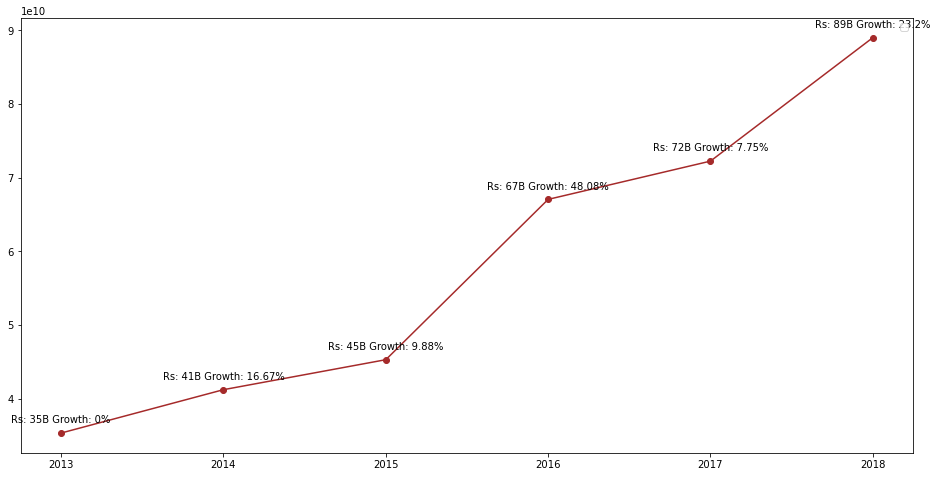

In [24]:
labels, companies, individuals = taxes_per_year()

xs = np.arange(len(labels))
ys = np.array(companies) + np.array(individuals)

fig, ax = plt.subplots(figsize=(16, 8), sharey=True)

ax.plot(xs,ys,'o-', color='Brown')

previous_revenue = 0
for x,y in zip(xs,ys):
    if(previous_revenue != 0 ):
        growth = round((y - previous_revenue) / previous_revenue * 100, 2)
    else:
        growth = 0
    ax.annotate("Rs: " + millify_by_records(y) + " Growth: " + str(growth) + "%",
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    previous_revenue = y

ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.legend();

plt.show();

The growth rate of the Pakistani economy is depicted in graph 2.

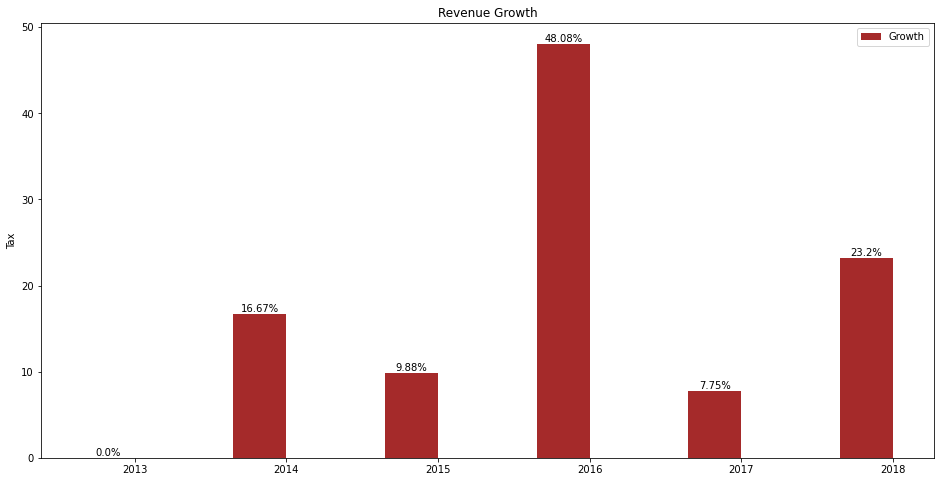

In [25]:
labels, companies, individuals = taxes_per_year()

x = np.arange(len(labels))
width = 0.35
y = np.array(companies) + np.array(individuals)

previous_revenue = 0
yg = []
for val in y:
    if previous_revenue != 0:
        growth = round((val - previous_revenue) / previous_revenue * 100, 2)
        yg.append(growth)
    else:
        yg.append(0)
    previous_revenue = val
        
fig, ax = plt.subplots(figsize=(16, 8), sharey=True)

bar = ax.bar(x - width/2, yg, width, label='Growth', color='Brown')

ax.set_ylabel('Tax')
ax.set_title('Revenue Growth')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for b in bar:
  height = b.get_height()
  label_x_pos = b.get_x() + b.get_width() / 2
  ax.text(label_x_pos, height, s=(str(height)+"%"), ha='center', va='bottom')

plt.show()

Individuals and businesses paid taxes to the government, as seen in graph 3.

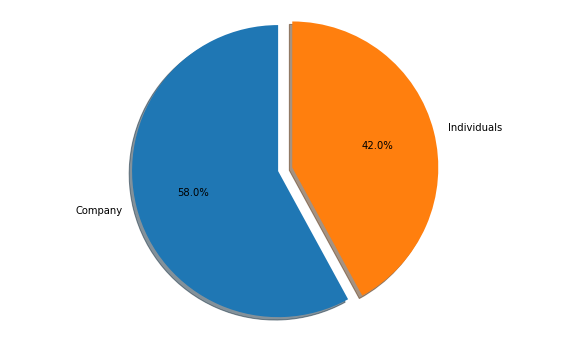

In [26]:
companies_tax = round(sum(df_companies['TaxPaid']))
individuals_tax = round(sum(df_individuals['TaxPaid']))

labels = 'Company', 'Individuals'
sizes = [companies_tax,individuals_tax]
explode = (0, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')
fig.set_size_inches(10, 6)

plt.show()

Individuals and businesses are compared in graph 4.

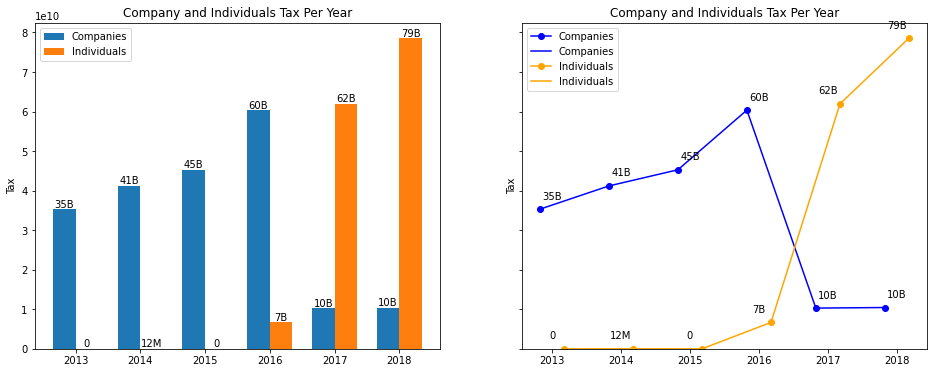

In [27]:
labels, companies, individuals = taxes_per_year()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1,2, figsize=(16, 6), sharey=True)

co_bar = ax[0].bar(x - width/2, companies, width, label='Companies')
indiv_bar = ax[0].bar(x + width/2, individuals, width, label='Individuals')

ax[0].set_ylabel('Tax')
ax[0].set_title('Company and Individuals Tax Per Year')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

for bar in co_bar:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax[0].text(label_x_pos, height, s=millify_by_records(height), ha='center', va='bottom')

for bar in indiv_bar:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax[0].text(label_x_pos, height, s=millify_by_records(height), ha='center', va='bottom')

ax[1].plot(x - width/2, companies,'o-', width, label='Companies', color='Blue')
ax[1].plot(x + width/2, individuals,'o-', width, label='Individuals', color='Orange')

for x_val,y_val in zip(x,companies):
    ax[1].annotate(millify_by_records(y_val),
                 (x_val,y_val),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

for x_val,y_val in zip(x,individuals):
    ax[1].annotate(millify_by_records(y_val),
                 (x_val,y_val),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

ax[1].set_ylabel('Tax')
ax[1].set_title('Company and Individuals Tax Per Year')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.show()

In [28]:
df_individuals['Province'] = df_individuals['NTN'].astype(str).str[0]
df_individuals['City'] = df_individuals['NTN'].astype(str).str[1]
df_individuals['City'].fillna(0, inplace=True)
df_individuals.loc[pd.to_numeric(df_individuals['NTN'].astype(str).str[-1])%2==0, 'Gender'] = 0
df_individuals.loc[pd.to_numeric(df_individuals['NTN'].astype(str).str[-1])%2==1, 'Gender'] = 1

In [29]:
def gender_pay_tax_per_year(df):
    years = np.sort(df['years'].unique())
    male = []
    female = []
    for yr in years:
        male_yr = len(df[(df['years'] == yr) & (df['Gender'] == 1)])
        female_yr = len(df[(df['years'] == yr) & (df['Gender'] == 0)])
        
        if male_yr > 0:
            male.append(male_yr)
        else:
            male.append(0)

        if female_yr > 0:
            female.append(female_yr)
        else:
            female.append(0)
    
    return years, male, female

Male and female tax payers are depicted in graph 5.

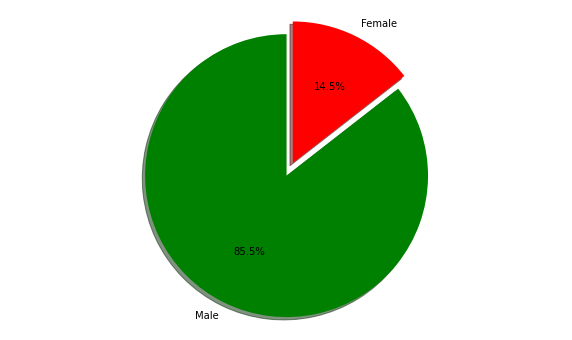

In [30]:
male = len(df_individuals.loc[df_individuals['Gender']==1])
female = len(df_individuals.loc[df_individuals['Gender']==0])

labels = 'Male', 'Female'
sizes = [male, female]
explode = (0, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['Green', 'Red'])
ax.axis('equal')
fig.set_size_inches(10, 6)

plt.show()

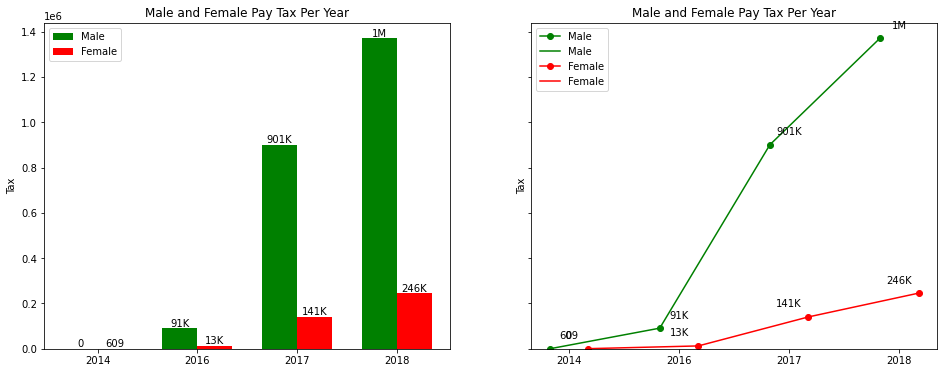

In [31]:
labels, male, female = gender_pay_tax_per_year(df_individuals)

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(1,2, figsize=(16, 6), sharey=True)

male_bar = ax[0].bar(x - width/2, male, width, label='Male', color='Green')
female_bar = ax[0].bar(x + width/2, female, width, label='Female', color='Red')

ax[0].set_ylabel('Tax')
ax[0].set_title('Male and Female Pay Tax Per Year')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

for bar in male_bar:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax[0].text(label_x_pos, height, s=millify_by_records(height), ha='center', va='bottom')

for bar in female_bar:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax[0].text(label_x_pos, height, s=millify_by_records(height), ha='center', va='bottom')

ax[1].plot(x - width/2, male,'o-', width, label='Male', color='Green')
ax[1].plot(x + width/2, female,'o-', width, label='Female', color='Red')

for x_val,y_val in zip(x, male):
    ax[1].annotate(millify_by_records(y_val),
                 (x_val,y_val),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

for x_val,y_val in zip(x, female):
    ax[1].annotate(millify_by_records(y_val),
                 (x_val,y_val),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

ax[1].set_ylabel('Tax')
ax[1].set_title('Male and Female Pay Tax Per Year')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.show()

In [33]:
df_cities = pd.read_csv('df_cities.csv')
df_individuals[['Province', 'City']] = df_individuals[['Province', 'City']].apply(pd.to_numeric)

df_individuals['Province'].loc[(df_individuals['Province']==0) | (df_individuals['Province']==8) | (df_individuals['Province']==9)] = np.NAN
df_individuals['City'].loc[df_individuals['City']==0] = np.NAN
df_individuals['Province'].bfill(axis ='rows', inplace=True)
df_individuals['Province'].ffill(axis ='rows', inplace=True)
df_individuals['City'].bfill(axis ='rows', inplace=True)
df_individuals['City'].ffill(axis ='rows', inplace=True)
df_indiv_locations = pd.merge(df_individuals, df_cities, on=['Province','City'], how='left')

Graph 6 depicts the amount of government tax collected by city.

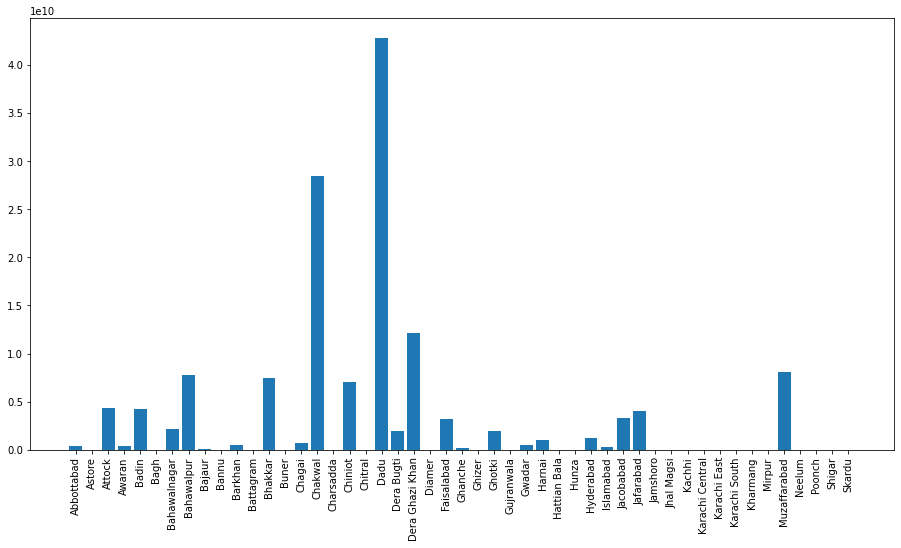

In [34]:
sr = df_indiv_locations.groupby('CityName')['TaxPaid'].agg('sum')
dict1 = sr.to_dict()
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])
k = dict1.keys()
v = dict1.values()
ax.bar(k,v)
plt.xticks(rotation='vertical')
plt.show()

Graph 7 depicts the amount of government tax collected by province.

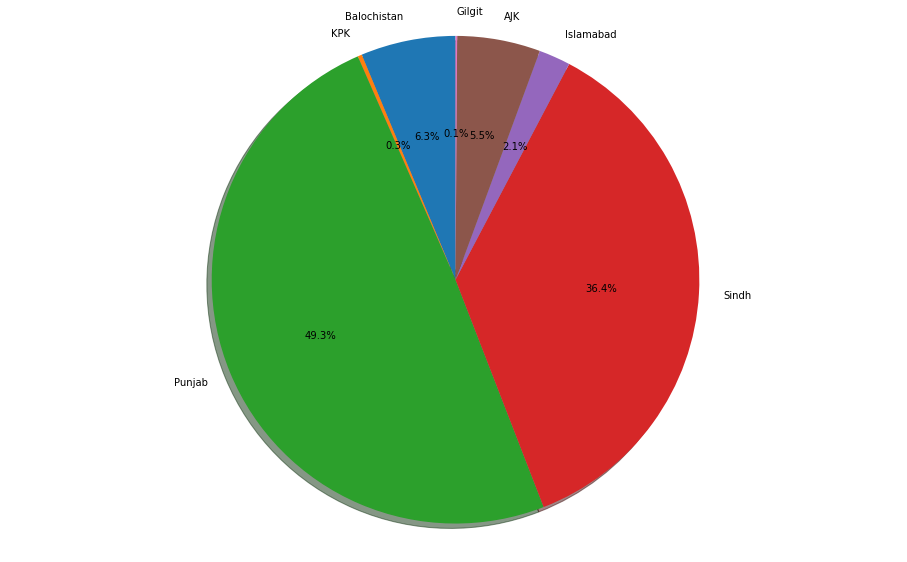

In [35]:
sr = df_indiv_locations.groupby('Province')['TaxPaid'].agg('sum')
dict1 = sr.to_dict()
k = dict1.keys()
v = dict1.values()

labels = 'Balochistan', 'KPK', 'Punjab', 'Sindh', 'Islamabad', 'AJK', 'Gilgit'
sizes = v
explode = (0, 0, 0, 0, 0, 0, 0)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
fig.set_size_inches(16,10)

plt.show()

In [36]:
df_pk = pd.read_csv('pakistan.csv')
df_pk.drop(['id'], axis=1, inplace=True)
df_pk.rename(columns = {df_pk.columns[0]:'CityName', df_pk.columns[1]:'Latitude', df_pk.columns[2]:'Longitude'}, inplace = True)
df_indiv_locations = pd.merge(df_indiv_locations, df_pk, on=['CityName'], how='left')
df_city = df_indiv_locations.drop_duplicates(subset ="CityName")

#### Map

In [37]:
df1 = df_city.dropna()
locations = df1[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()
map1 = folium.Map(location=[30.3753, 69.3451], zoom_start=5)
marker_cluster = MarkerCluster().add_to(map1)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df1['CityName'].iloc[point]).add_to(marker_cluster)
map1